# Radius Valley Slope Estimation - MCMC Method - Period

This Python notebook uses Bayesian methods to estimate the final slope and the associated uncertainties. Bayesian methods are preferred due to the proven accuracy of Affine Invariant Markov Chain Monte Carlo (MCMC) Ensemble sampling used with the $emcee$ Python module and uses these statistical methods to reduce computational biases and determine final uncertainties. The complete analysis process for all planetary and stellar parameters is as follows:

1. Start with the **RV_Gap_Bin-Period** notebook which first converts all data to log-log values so the slope can be estimated and visualized in log-log scale.

2. Use the Gap Bin method for group sizes ranging from 1 to 20 and for bin sizes ranging from 10 to 60. In theory, this can generate over 3000 slope data points, but there will be group and bin size combinations where bi-modal Gaussian curves cannot be generated. In general, there will usually be 100 to 1000 data points available for statistical analysis.

3. Remove data outliers using interquartile range (IQR) filtering where we calculate the IQR value. We then take 1.5 times the IQR and subtract this value from 1st quartile (Q1) and add this value to the 3rd quartile (Q3) to establish outlier thresholds. Any data points less than 1.5IQR below Q1 or more than 1.5IQR above Q3 are considered outliers and discarded.

4. Use linear regression as a sanity check to get initial slope and intercept which can be used as an initial guess for step 5.

5. Then use Bayesian methods to estimate the final slope and the associated uncertainties. This notebook where **RV_Slope_{x-axis}** notebooks, where **{x-axis}** can be **Period**, **Flux** or **Mass**.

6. Overlay the results of the Bayesian method to determine the slope and intercept for the 2D power law equation on the KDE contour plot of the sample planets for each horizontal parameter (i.e., orbital period, insolation flux or stellar mass). See **RV_KDE_Plots** notebook.

7. Repeat steps 2 through 6 using a filtered sample of stellar masses between 0.8 and 1.2 $M_⊙$ to see if planets with host stars near 1 $M_⊙$ show better alignment to model data or previous observational studies. Set **MASS_FILTER = False** for full sample and **MASS_FILTER = True** for filtered sample.

This Python notebook is used for step 5 of the Radius Valley slope estimation process and requires the **Slope_Data_P_IQR.csv** (full sample) and **Slope_Data_P_IQR_f.csv** (filtered sample) files. Final results used in **RV_KDE_Plots** notebook can be copied from the last cell.

## Imports
Import all the needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
import scipy
from scipy import stats
from IPython.display import display, Math

%matplotlib inline
fig_size = plt.rcParams['figure.figsize'] = (20,15)   # Make plots as wide as notebook page

C:\Users\Dajordan78\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
## Set Mass Filter flag for filtered sample between 0.8 to 1.2 Msun
MASS_FILTER = False

## Get Slope Data
Get slope data generated by Radius Valley Gap Bin Method Python notebooks.

In [3]:
if MASS_FILTER == True:
    slope_data = pd.read_csv('Slope_Data_P_IQR_f.csv')         #Get RV slope data for filtered sample
else:
    slope_data = pd.read_csv('Slope_Data_P_IQR.csv')           #Get RV slope data for full sample
slope_data

,Rp_log,P_log_mid,Rp,P_mid,bins,grps,i
0,0.673712,1.224134,1.961504,3.401221,10.0,2.0,1.0
1,0.720770,0.986395,2.056016,2.681551,10.0,3.0,1.0
2,0.541041,2.423570,1.717794,11.286083,10.0,3.0,2.0
3,0.766731,0.858200,2.152717,2.358912,10.0,4.0,1.0
4,0.539967,2.077406,1.715950,7.983735,10.0,4.0,2.0
...,...,...,...,...,...,...,...
620,0.602002,1.849297,1.825771,6.355353,59.0,5.0,2.0
621,0.484056,2.427961,1.622643,11.335743,59.0,5.0,3.0
622,0.768905,3.033736,2.157403,20.774701,59.0,5.0,4.0
623,0.873993,0.524608,2.396460,1.689797,59.0,12.0,1.0


## Plot Radius Valley Slope Data
Plot raw data with regresssion best fit.

-0.11065143686058472 0.8683560192934933 0.004634453564315174 -0.04188335638293024


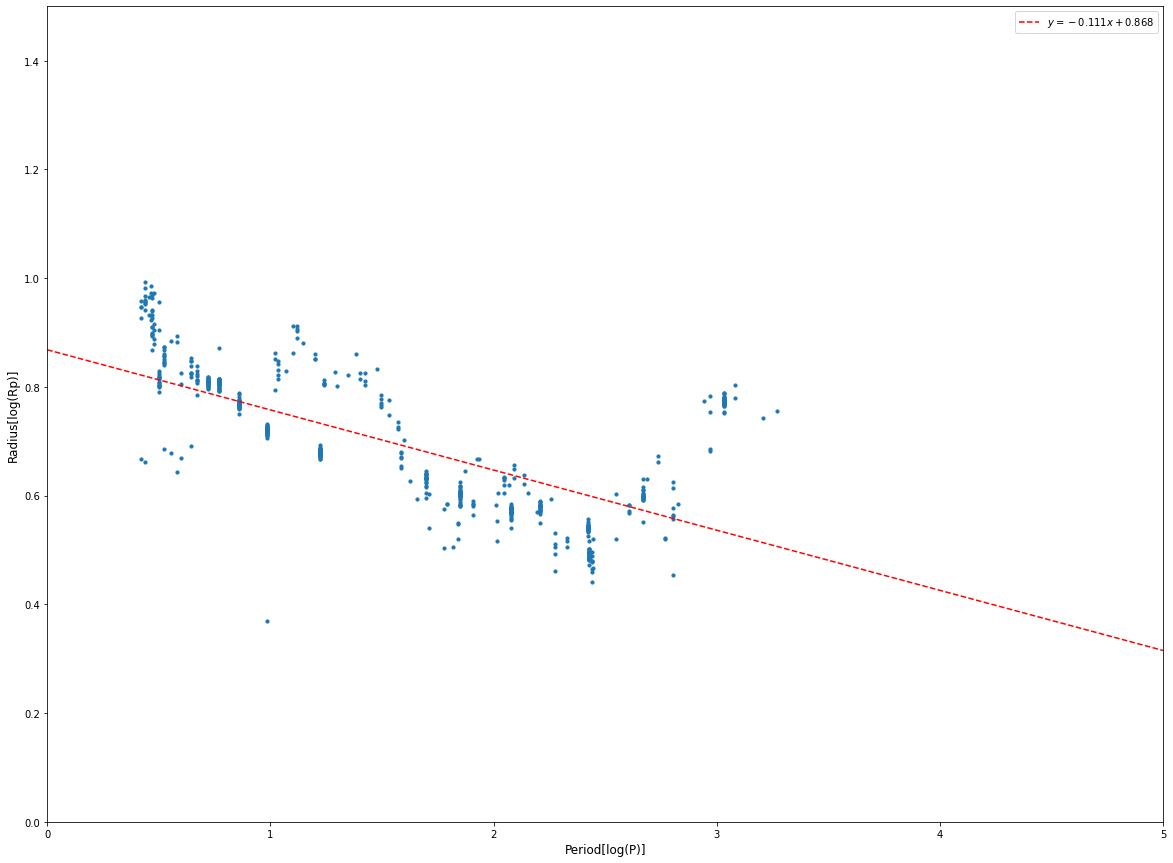

In [4]:
m_lr, b_lr, r_value, p_value, std_err = stats.linregress(slope_data.P_log_mid,slope_data.Rp_log)
frac_err = std_err/m_lr
print(m_lr, b_lr, std_err, frac_err)
plt.xlim(0, 5)
plt.ylim(0, 1.5)
plt.xlabel('Period[log(P)]', fontsize=12)
plt.ylabel('Radius[log(Rp)]', fontsize=12)
plt.scatter(slope_data.P_log_mid,slope_data.Rp_log, s=10)
plt.axline(xy1=(0, b_lr), slope=m_lr, color='r', linestyle="--", label=f'$y = {m_lr:.3f}x {b_lr:+.3f}$')
plt.legend()
#slope_data

 ## Define Model
 Return scaled model flux value for model temp at wavelength observed

In [5]:
def model(theta, x):                                      # model
    m, b = theta  
    return m*x + b

## Define Maximum Likelihood estimation function

The $emcee$ example assumes the errors provided are not completely correct and the variance is
underestimated by some fractional amount:  $f$.

In mathematical notation, the final likelihood function is:

$$
    \ln\,p(y\,|\,x,\sigma,m,b,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{(y_n-m\,x_n-b)^2}{s_n^2}
        + \ln \left ( 2\pi\,s_n^2 \right )
    \right]
$$

where

$$
    s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .
$$


In [6]:
def lnlike(theta, x, y, y_err):
    lin_model = model(theta, x)
    sigma2 = y_err**2 + lin_model**2 * np.exp(2 * log_f)  # Variance correction from emcee example
    ln_like = -0.5 * np.sum((y - lin_model)**2 / sigma2 + np.log(sigma2))  # Likelihood from emcee example
    return ln_like

## Define Log Priors
Define limits of theta (slope & intercept)


In [7]:
def lnprior(theta):
    m, b = theta
    if -1 < m <  1 and -1 < b < 1.4:     # Set slope and intercept range for sampling
        return 0.0                                            # 0.0 if True
    return -np.inf                                            # -inf if True

## Define Log Probability
Define posterior probability function


In [8]:
def lnprob(theta, x, y, y_err):
    lp = lnprior(theta)                              # check if sample vales of theta in range selected in lnprior
    if not np.isfinite(lp):                          # if not, then don't use
        return -np.inf
    return lp + lnlike(theta, x, y, y_err)           # if so, then use lnlike value

## Define EMCEE Data

In [20]:
Rp_log_err = frac_err * slope_data.Rp_log
data = (slope_data.P_log_mid, slope_data.Rp_log, Rp_log_err)     # data = P_log_mid, Rp_log and Rp_Log error
nwalkers = 50                                      # Number of walkers
niter = 5000                                       # of iterations per walker
f = 0.1                                            # Variance correction from emcee example
log_f = np.log(f)
initial = np.array([m_lr,b_lr])                    # Initial values for theta (m, b), using middle of ranges
ndim = len(initial)                                # Number of dimensions = number of theta parameters
p0 = [np.array(initial) + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]  # Initial values for walkers
#print (p0)

## Define Main
This section is pulled verbatim from $emcee$ examples. Only adjusted Burn-in in testing.

In [21]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data) # Using default moves, etc.
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 200, progress=True)   # May need to adjust burn-in depeding on data
    sampler.reset()
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)
    return sampler, pos, prob, state

## Run Sampler

This section is pulled verbatim from $emcee$ example

In [22]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.19it/s]


Running production...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:00<00:00, 16.30it/s]


## View Sampler Behavoir
Look at sampler chain plots to see sampler behavior. Should be consistent range of values for all steps. If not, may need to adjust burn-in value.

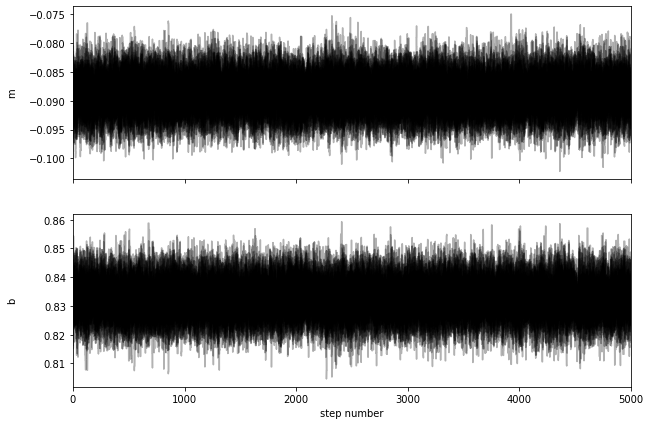

In [23]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

## Corner Plot
Show Posterior distribition spread in corner plot for slope and intercept values. This plot should be symetrical about the diagonal to show good sampling convergence to form Gaussian distributions.

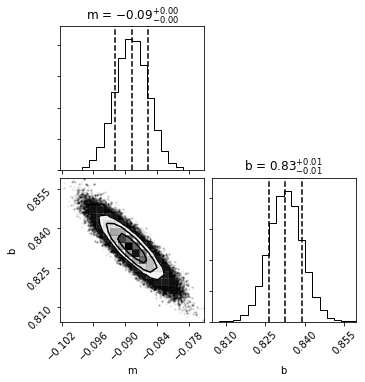

In [24]:
labels = ['m','b']
samples = sampler.flatchain                                     # Per example
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

## Best Fit Values
Find the best fit values of theta where probablity (lnlike) is maximum value

In [25]:
theta_max = samples[np.argmax(sampler.flatlnprobability)]       # Per example
print ("Theta max: ",theta_max)
m_MC = theta_max[0]                            # 
b_MC = theta_max[1] 
print ("m =", m_MC)                             # 
print ("b =", b_MC)                             # 

Theta max:  [-0.08877636  0.83259711]
m = -0.08877636312952826
b = 0.8325971113828218


## Calculate Uncertainties
Derive 1 sigma uncertainties for all parameters

In [26]:
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    if i == 0:
        txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], 'm_{MC}')
        display(Math(txt))
        m_MC_err_neg = q[0]
        m_MC_err_pls = q[1]
    if i == 1:
        txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], 'b_{MC}')
        display(Math(txt))
        b_MC_err_neg = q[0]
        b_MC_err_pls = q[1]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Calculate Uncertianties - Bootstrap Method 
Use Bootstrap method to show 1 sigma uncertainties for all parameters for comparison with MCMC and Linear Regression methods

In [27]:
# Define bootstrap function
def bootstrap(data, R=5000):
 
    m=b=i=ss=0
    bstrap_data = pd.DataFrame(data={'m': m, 'b': b, 'smpl_siz': ss}, index=[i])
    n = len(data)
 
    for i in range(R):
        sampled_data = data.sample(n=1000, replace=True)
        ss = len(sampled_data)
        m, b, r_value, p_value, std_err = stats.linregress(sampled_data.P_log_mid,sampled_data.Rp_log)
        bstrap_data.loc[i] = [m, b, ss]
 
    return bstrap_data
                                     
bstrap_data = bootstrap(slope_data)

In [28]:
# Get values from boostrap data
m_bs = bstrap_data.m.mean()
m_bs_err = bstrap_data.m.std()
b_bs = bstrap_data.b.mean()
b_bs_err = bstrap_data.b.std()
print(m_bs,m_bs_err, b_bs,b_bs_err)

-0.11069883757014372 0.005115622072205063 0.8683590204592403 0.007118739681051159


## Compare All Slope Estimation Methods

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

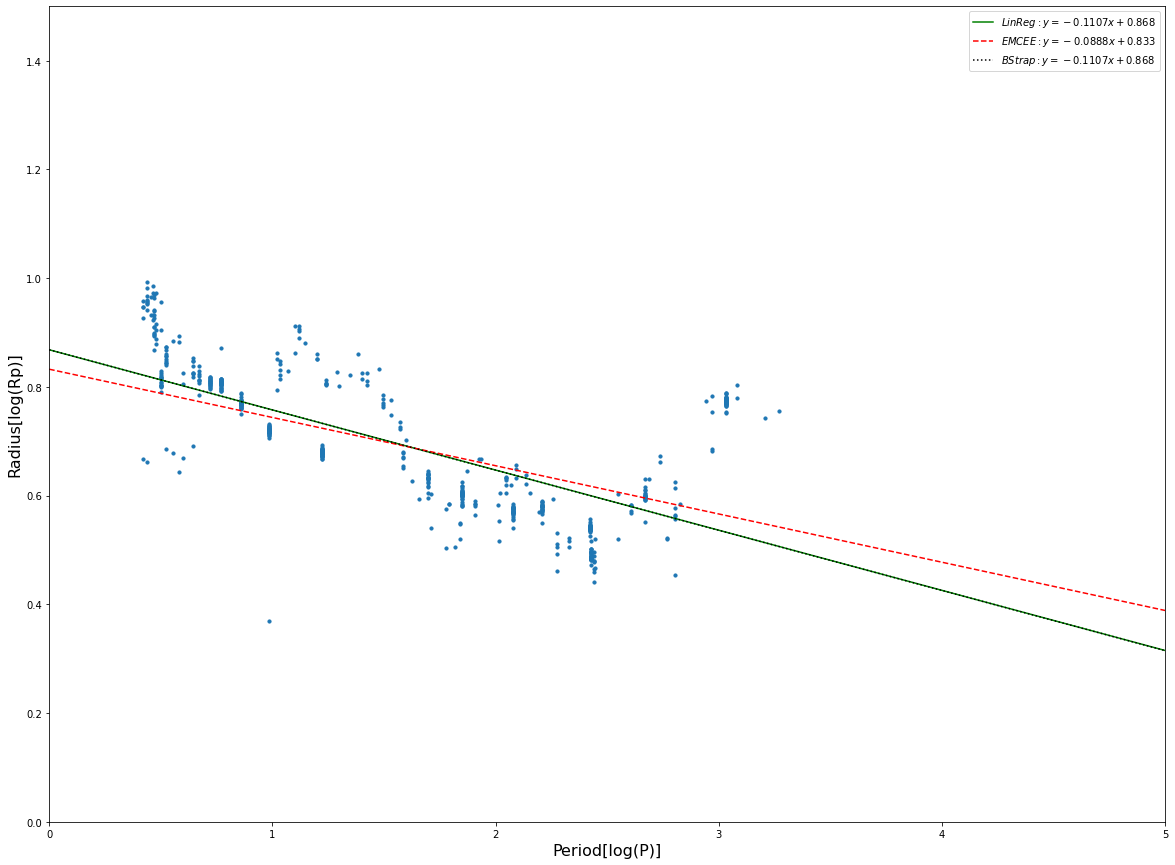

In [29]:
# Show all values for comparing all methods for fitting slope and intercept to data with uncertainties
plt.xlim(0, 5)
plt.ylim(0, 1.5)
plt.xlabel('Period[log(P)]', fontsize=16)
plt.ylabel('Radius[log(Rp)]', fontsize=16)
plt.scatter(slope_data.P_log_mid,slope_data.Rp_log, s=10)
plt.axline(xy1=(0, b_lr), slope=m_lr, color='g', linestyle="-", label=f'$Lin Reg: y = {m_lr:.4f}x {b_lr:+.3f}$')
plt.axline(xy1=(0, b_MC), slope=m_MC, color='r', linestyle="--", label=f'$EMCEE: y = {m_MC:.4f}x {b_MC:+.3f}$')
plt.axline(xy1=(0, b_bs), slope=m_bs, color='k', linestyle="dotted", label=f'$BStrap: y = {m_bs:.4f}x {b_bs:+.3f}$')
plt.legend()
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt = txt.format(m_lr, std_err, std_err, 'm_{LR}')
display(Math(txt))
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt = txt.format(b_lr, std_err, std_err, 'b_{LR}')
display(Math(txt))
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt = txt.format(m_MC, m_MC_err_neg, m_MC_err_pls, 'm_{MC}')
display(Math(txt))
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt = txt.format(b_MC, b_MC_err_neg, b_MC_err_pls, 'b_{MC}')
display(Math(txt))
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt = txt.format(m_bs, m_bs_err, m_bs_err, 'm_{BS}')
display(Math(txt))
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt = txt.format(b_bs, b_bs_err, b_bs_err, 'b_{BS}')
display(Math(txt))

## Final Results for Slope using MCMC
Copy these values into the **RV_KDE_Plots** notebook.

In [30]:
print('Slope m = ', round(m_MC, 4))
print('Slope Negative Error = ', round(m_MC_err_neg, 4))
print('Slope Positive Error = ', round(m_MC_err_pls,4))
print('Intercept b = ', round(b_MC, 4))
print('Intercept Negative Error = ', round(b_MC_err_neg, 4))
print('Intercept Positive Error = ', round(b_MC_err_pls, 4))

Slope m =  -0.0888
Slope Negative Error =  0.0032
Slope Positive Error =  0.0031
Intercept b =  0.8326
Intercept Negative Error =  0.0063
Intercept Positive Error =  0.0063
